<a href="https://colab.research.google.com/github/aneupanetims2016/Fall-2020/blob/master/Pneumonia_of_Biostatistics_Lab_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flashtorch
!pip install barbar

  Created wheel for flashtorch: filename=flashtorch-0.1.3-cp36-none-any.whl size=26248 sha256=94bc54855c74f465b4731b4e8c6505d6617bac23a1def2ca4f1993648548fa99
  Stored in directory: /root/.cache/pip/wheels/03/6d/b1/2d3c5987b69e900fcceceeef39d3ed92dfe46ba1359b9c79f8
Successfully built flashtorch


In [2]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools
from sklearn.metrics import confusion_matrix

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-qaehkwiw
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-qaehkwiw
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=7323 sha256=d918cbafbea1a591ddc14984466372c56a7345e41eb34358cbc69f527783a778
  Stored in directory: /tmp/pip-ephem-wheel-cache-9qo9rly0/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create new folder on your google drive like below:

In [4]:
data_dir = '/content/drive/My Drive/Data1/chest_xray/chest_xray'

In [5]:
os.chdir(data_dir)


In [6]:
dataset_labels =["PNEUMONIA", "NORMAL"] #<--- Replace with your labels 

In [7]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [8]:
batch_size = 16
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
dataset_sizes

{'train': 5216, 'valid': 640}

In [10]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

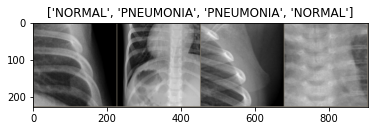

In [11]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[:4]
classes = classes[:4] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[x] for x in classes])

In [12]:
def train_model(model, num_epochs=25):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()  
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [13]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [14]:
model = train_model(model, num_epochs=30)

Epoch:  1 / 30
Train  Acc: 0.89
Valid  Acc: 0.92
#######################
Epoch:  2 / 30
Train  Acc: 0.92
Valid  Acc: 0.89
#######################
Epoch:  3 / 30
Train  Acc: 0.94
Valid  Acc: 0.93
#######################
Epoch:  4 / 30
Train  Acc: 0.94
Valid  Acc: 0.88
#######################
Epoch:  5 / 30
Train  Acc: 0.94
Valid  Acc: 0.93
#######################
Epoch:  6 / 30
Train  Acc: 0.94
Valid  Acc: 0.95
#######################
Epoch:  7 / 30
Train  Acc: 0.95
Valid  Acc: 0.93
#######################
Epoch:  8 / 30
Train  Acc: 0.96
Valid  Acc: 0.93
#######################
Epoch:  9 / 30
Train  Acc: 0.96
Valid  Acc: 0.93
#######################
Epoch:  10 / 30
Train  Acc: 0.96
Valid  Acc: 0.93
#######################
Epoch:  11 / 30
Train  Acc: 0.96
Valid  Acc: 0.94
#######################
Epoch:  12 / 30
Train  Acc: 0.96
Valid  Acc: 0.95
#######################
Epoch:  13 / 30
Train  Acc: 0.96
Valid  Acc: 0.94
#######################
Epoch:  14 / 30
Train  Acc: 0.96
Valid  Acc: 0.

In [15]:
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[preds[j]] + '     class: ' + dataset_labels[labels[j]]
            imshow(inputs.cpu().data[j],title1)

            if index == num_images:
                return

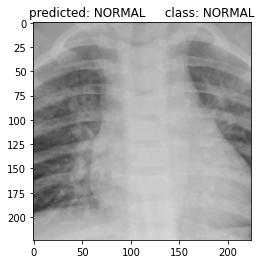

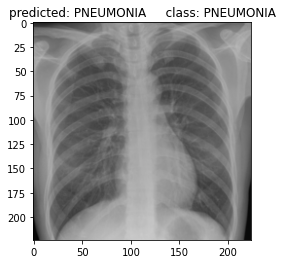

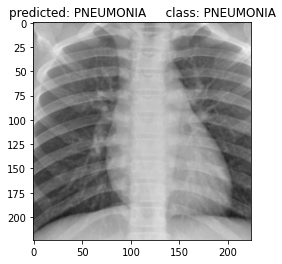

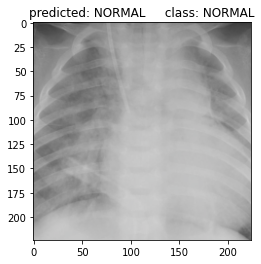

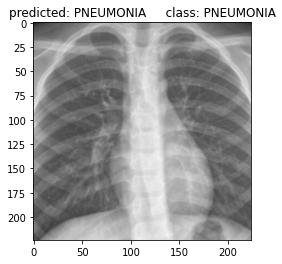

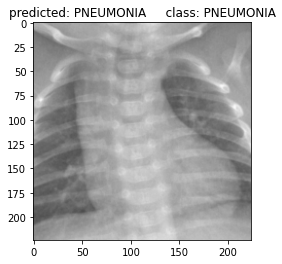

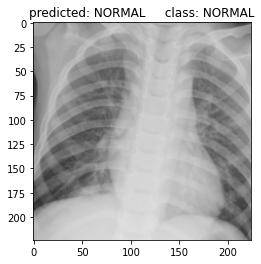

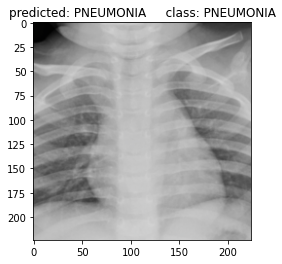

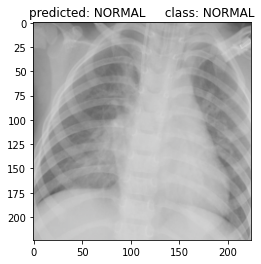

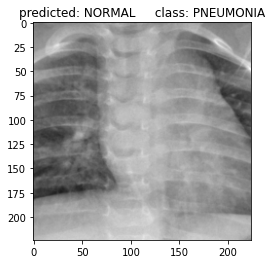

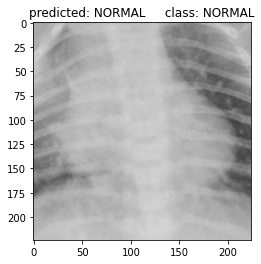

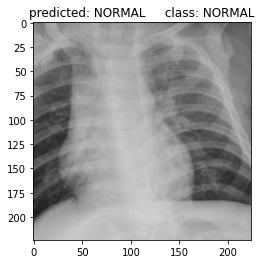

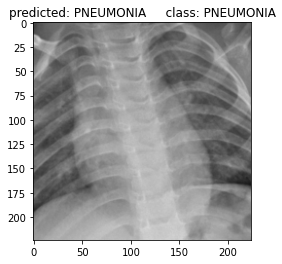

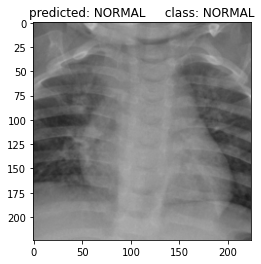

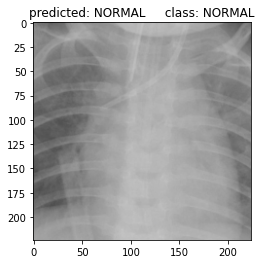

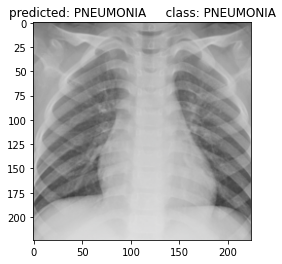

In [16]:
visualize_model(model)

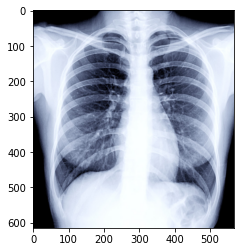

In [17]:
image = io.imread('https://d2ebzu6go672f3.cloudfront.net/media/content/images/cr/ddca3f92-4b8e-4672-bb6b-f3594ad4e304.jpg')
plt.imshow(image);

In [18]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [20]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [21]:
print('predicted: ' + dataset_labels[preds])

predicted: NORMAL


In [ ]:
#batch_size = 1024 #large batch size so we test all the data
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
#dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
#dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
#class_names = image_datasets['train'].classes
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
inputs,labels = next(iter(dataloaders['valid']))
inputs = inputs.to(device)
labels = labels.detach().cpu().numpy()

In [24]:
outputs = model(inputs)
preds = torch.max(outputs, 1)[1].detach().cpu().numpy()

In [25]:
cm = confusion_matrix(preds.reshape(-1),labels)

In [26]:
print("Confusion Matrix : ")
cm


Confusion Matrix : 


array([[6, 0],
       [1, 9]])

Calculate each of the following:

Accuracy (ACC)
The percentage of correctly identified true and false samples.

True positive (TP)
The number of correctly identified samples. 

True negative (TN)
The number of correctly identified negative samples.
 
False positive (FP)
The number of wrongly identified samples, i.e., a commonly called a "false alarm". 
 
False negative (FN)
The number of wrongly identified negative samples. 

Recall (REC)
This metric is also frequently called sensitivity, probability of detection and true positive rate, and it is the ratio of samples that are correctly identified as positive among all existing positive samples.
 
Precision (PREC)
This metric is also frequently called the positive predictive value, and shows the ratio of samples that are correctly identified as positive.

Specificity (SPEC)
This metric is frequently called the true negative rate, and shows the ratio of negatives that are correctly identified as such.
 
F1 score (F1)
A measure of a test’s accuracy by calculating the harmonic mean of the precision and recall.


In [32]:
cm[0,0] # =TN We predicted no, and they don't have the disease. Total number of sample was 16

6

In [28]:
cm[1,1] #=TP These are cases in which we predicted yes (they have the disease), and they do have the disease.

9

In [29]:
cm[0,1] #=FP We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")

0

In [30]:
cm[1,0] #=FN We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

1

In [44]:
#Total(n) = 16
n=16
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
ACC=(TP+TN)/n #Accuracy
print('Accuracy is', ACC)

Accuracy is 0.9375


In [ ]:
#Recall

In [46]:
REC= TP/(TP+FN) #RECALL
print ('Recall is', REC)

Recall is 0.9


In [48]:
PREC=TP/(TP+FP) #precision
print('Precision is', PREC)


Precision is 1.0


In [51]:
SPEC= TN/(TN+FP) # Specificity
print('Specificity is',SPEC)

Specificity is 1.0


In [53]:
#F1 score
F1= (2*PREC*REC)/(PREC+REC)
print('F1 is',F1)

F1 is 0.9473684210526316
